In [1]:
from Generator import Generator
from test_backendclient import TestBackendClient
import logging
import sys


# 기존 핸들러들 제거 (중복 방지)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# 로깅 설정 추가 (콘솔 + 파일)
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),  # 노트북 출력으로 로그 표시
    ]
)

# 루트 로거 레벨 설정
logger = logging.getLogger()
logger.setLevel(logging.INFO)



generator = Generator()
backend_client = TestBackendClient()

2025-10-11 23:55:15,869 - test_backendclient - INFO - Initialized TestBackendClient


In [2]:
from typing import List, TypedDict
from models import ScenarioCreate, ScenarioStepCreate
from pydantic import BaseModel, Field

from test_backendclient import TestBackendClient
import json

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate

# -------------------- 1. AgentState 및 중간 결과 정의 --------------------
class ChunkAnalysisResult(BaseModel):
    """Map 단계에서 필터링된 중요 아티팩트 리스트"""
    important_artifacts: List[dict] = Field(
        description="정보유출과 관련된 중요한 아티팩트만 선별한 리스트. 각 아티팩트는 원본 데이터 구조 그대로 유지."
    )
    chunk_summary: str = Field(
        description="이 청크에서 발견된 의심 활동을 한 문장으로 간단히 요약 (예: '악성 파일 다운로드 및 실행')"
    )

class AgentState(TypedDict):
    artifact_chunks: List[List[dict]]
    current_chunk_index: int
    intermediate_results: List[ChunkAnalysisResult]
    final_report: ScenarioCreate | None
    job_id: str
    task_id: str

In [3]:
# -------------------- 아티팩트 로딩 및 청크 분할 --------------------
def load_artifacts(task_id: str) -> List[dict]:
    backend_client = TestBackendClient()
    job_id = "test+job_id"
    return backend_client.load_artifacts(task_id, job_id)

def chunk_artifacts(artifacts: List[dict], chunk_size: int = 50) -> List[List[dict]]:
    return [artifacts[i:i+chunk_size] for i in range(0, len(artifacts), chunk_size)]

def pretty_print_scenario(scenario: ScenarioCreate):
    """시나리오 객체를 받아 가독성 좋은 보고서 형태로 출력합니다."""
    
    print("="*80)
    print(f"📜 시나리오 분석 보고서: {scenario.name}")
    print("="*80)
    
    print("\n[ 보고서 개요 ]")
    print(f"  - {scenario.description}")
    
    print("\n[ 식별 정보 ]")
    print(f"  - Job ID: {scenario.job_id}")
    print(f"  - Task ID: {scenario.task_id}")
    
    print("\n[ 재구성된 공격 단계 (Timeline) ]")
    print("-" * 80)
    
    if not scenario.steps:
        print("  (분석된 단계가 없습니다.)")
    else:
        # 시간 순서대로 정렬 (이미 정렬되어 있지만 안전장치)
        sorted_steps = sorted(scenario.steps, key=lambda s: s.order_no)
        
        for step in sorted_steps:
            # datetime 객체를 보기 좋은 문자열로 포맷팅
            timestamp_str = step.timestamp.strftime('%Y-%m-%d %H:%M:%S') if step.timestamp else ""
            
            # 아티팩트 ID 리스트를 콤마로 구분된 문자열로 변환
            artifacts_str = ", ".join(step.artifact_ids)
            
            print(f"\n▶ Step {step.order_no}: [{timestamp_str}]")
            print(f"  - 내용: {step.description}")
            print(f"  - 연관 아티팩트: [{artifacts_str}]")
    
    print("\n" + "="*80)

In [4]:
# -------------------- 2. Map 단계: analyze_chunk --------------------
llm_small = init_chat_model("google_genai:gemini-2.5-flash-lite", temperature=0)
llm_large = init_chat_model("google_genai:gemini-2.5-pro", temperature=0)

def analyze_chunk(state: AgentState):
    """
    Small model을 사용하여 청크에서 중요한 아티팩트만 빠르게 필터링.
    원본 데이터를 그대로 유지하여 Reduce 단계로 전달.
    """
    chunk_idx = state["current_chunk_index"]
    artifact_chunks = state["artifact_chunks"]
    chunk = artifact_chunks[chunk_idx]

    # 아티팩트를 간략하게 포맷 (small model용 - 토큰 절약)
    artifacts_summary = []
    for idx, artifact in enumerate(chunk):
        # 핵심 정보만 추출 (summary가 없으므로 data에서 주요 정보 추출)
        artifact_type = artifact.get('artifact_type', 'N/A')
        # collected_at = artifact.get('collected_at', 'N/A')
        artifact_id = artifact.get('id', 'N/A')
        
        # data 필드에서 중요한 정보만 선별
        data = artifact.get('data', {})
        # data를 간략하게 요약 (너무 길면 토큰 낭비)
        data_summary = {}
        for key in ['file_name', 'file_path', 'process_name', 'command_line', 
                    'url', 'device_name', 'sender', 'receiver', 'subject']:
            if key in data and data[key]:
                data_summary[key] = str(data[key])[:100]  # 최대 100자로 제한
        
        artifacts_summary.append({
            "index": idx,
            "type": artifact_type,
            "key_data": data_summary,  # summary 대신 data의 핵심 정보 사용
            "id": artifact_id
        })
    
    artifacts_text = json.dumps(artifacts_summary, ensure_ascii=False, indent=2)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 엄격한 보안 분석가입니다. 
**정보유출 시나리오에 직접적으로 연관된 아티팩트만** 선택하세요.

**필터링 우선순위 (점수제):**

🔴 HIGH (반드시 포함):
- 외부로 파일 전송: messenger_file, email_attachment, usb_device
- 민감 파일 접근: 회사 기밀, 개인정보 파일
- 악성 도구 실행: 암호화, 영구 삭제 도구 등

🟡 MEDIUM (의심스러운 경우만):
- 비정상 시간대 접근 (새벽 2-5시)
- 대량 파일 처리
- 시스템 로그 삭제 시도

⚪ LOW (제외):
- 일반 브라우저 방문
- 정상 업무 파일 접근
- 시스템 자동 생성 로그
- 현재로부터 6개월 이전 데이터

**선택 기준:**
1. HIGH 우선순위에 해당하는가?
2. MEDIUM + 추가 의심 요소 2개 이상?
3. 아니면 제외

**목표: 청크당 최대 5-10개만 선택** (전체의 10% 이하)

**출력:**
- important_indices: HIGH + 명확한 MEDIUM만 포함
- chunk_summary: 선택한 이유를 명확히"""),
        ("human", "아티팩트 목록:\n{artifacts_text}\n\n청크 크기: {chunk_size}개\n목표 선택 개수: 최대 {max_select}개")
    ])
    
    
    # 필터링 결과 (index 리스트) 받기
    class FilterResult(BaseModel):
        important_indices: List[int] = Field(description="중요한 아티팩트의 index 번호 리스트")
        chunk_summary: str = Field(description="청크의 간단한 요약 (한 문장)")
    
    structured_llm = llm_small.with_structured_output(FilterResult)
    filter_chain = prompt | structured_llm
    
    try:
        # 청크 크기에 따라 최대 선택 개수 동적 계산
        chunk_size = len(chunk)
        max_select = max(5, chunk_size // 50)  # 최소 5개, 또는 2%
        
        filter_result = filter_chain.invoke({
            "artifacts_text": artifacts_text,
            "chunk_size": chunk_size,
            "max_select": max_select
        })
        
        # LLM이 None을 반환하거나 필수 필드가 없는 경우 처리
        if filter_result is None or not hasattr(filter_result, 'important_indices'):
            print(f"⚠️  청크 {chunk_idx + 1}: LLM 응답 오류 - 빈 결과로 처리")
            important_artifacts = []
            chunk_summary = "분석 실패"
        else:
            # 선택된 아티팩트의 원본 데이터 추출
            important_artifacts = [
                chunk[idx] for idx in filter_result.important_indices 
                if 0 <= idx < len(chunk)
            ]
            
            # 유의미한 데이터가 없는 경우 처리
            if not important_artifacts:
                print(f"⚠️  청크 {chunk_idx + 1}: 유의미한 데이터 없음 (스킵)")
                chunk_summary = "관련성 없는 데이터"
            else:
                chunk_summary = filter_result.chunk_summary
                print(f"✅ 청크 {chunk_idx + 1}: {len(important_artifacts)}개 중요 아티팩트 발견")
    
    except Exception as e:
        print(f"❌ 청크 {chunk_idx + 1}: 분석 중 에러 발생 - {str(e)}")
        important_artifacts = []
        chunk_summary = f"분석 오류: {type(e).__name__}"
    
    chunk_result = ChunkAnalysisResult(
        important_artifacts=important_artifacts,
        chunk_summary=chunk_summary
    )

    # 중간 결과 누적
    new_results = state.get("intermediate_results", []) + [chunk_result]
    return {
        "current_chunk_index": chunk_idx + 1,
        "intermediate_results": new_results
    }

In [5]:
# -------------------- 3. Reduce 단계: synthesize_report --------------------
def synthesize_report(state: AgentState):
    """
    필터링된 중요 아티팩트들을 Large model로 정밀 분석하여 최종 보고서 생성.
    """
    intermediate_results = state["intermediate_results"]
    job_id = state["job_id"]
    task_id = state["task_id"]

    # 모든 중요 아티팩트를 하나로 모으기
    all_important_artifacts = []
    chunk_summaries = []
    
    for idx, result in enumerate(intermediate_results, 1):
        # 유의미한 데이터가 있는 청크만 포함
        if result.important_artifacts:
            chunk_summaries.append(f"청크 {idx}: {result.chunk_summary}")
            all_important_artifacts.extend(result.important_artifacts)
    
    # 전체적으로 유의미한 데이터가 없는 경우 처리
    if not all_important_artifacts:
        print("\n❌ 전체 청크에서 유의미한 데이터를 찾지 못했습니다.")
        # 빈 보고서 반환
        return {
            "final_report": ScenarioCreate(
                name="분석 결과 없음",
                description="제공된 아티팩트에서 정보유출과 관련된 유의미한 데이터를 발견하지 못했습니다.",
                job_id=job_id,
                task_id=task_id,
                steps=[],
                report_detail_id=None
            )
        }
    
    print(f"\n📊 총 {len(all_important_artifacts)}개의 중요 아티팩트 발견")
    
    # 전체 요약
    chunks_overview = "\n".join(chunk_summaries)
    
    # 아티팩트를 상세하게 포맷 (Large model은 토큰 여유 있음)
    formatted_artifacts = []
    for artifact in all_important_artifacts:
        artifact_type = artifact.get('artifact_type', 'N/A')
        artifact_id = artifact.get('id', 'N/A')
        collected_at = artifact.get('collected_at', 'N/A')
        
        # data 필드 전체 포함 (Large model은 상세 분석 가능)
        data_details = json.dumps(artifact.get('data', {}), ensure_ascii=False, indent=2)
        
        formatted_string = (
            f"[ID: {artifact_id}]\n"
            f"  유형: {artifact_type}\n"
            f"  데이터:\n{data_details}"
        )
        formatted_artifacts.append(formatted_string)
    
    artifacts_detail = "\n\n".join(formatted_artifacts)

    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""당신은 내부정보 유출 사고 분석 및 보고서 작성 전문가입니다.

**현재 상황:**
여러 청크에서 필터링된 아티팩트들이 제공되었습니다.
각 청크의 간단한 요약:
{chunks_overview}

**당신의 임무:**
제공된 모든 아티팩트의 원본 데이터를 면밀히 분석하여,
**논리적인 행위 단위**로 재구성된 정보유출 시나리오 보고서를 작성하세요.

**보고서 작성 규칙:**

1. **Step 생성 - 행위 중심:**
   - 각 Step = 하나의 의미 있는 공격 행위
   - 유사한 행위는 하나로 통합
   - 시간 순서대로 정렬

2. **artifact_ids:**
   - 각 Step에 관련된 모든 아티팩트 ID 포함
   - ID는 [ID: xxx] 형식으로 표시됨

3. **timestamp:**
   - "수집 시각" 필드에서 추출
   - ISO 8601 형식 (예: "2025-09-23T04:55:59")
   - 여러 아티팩트를 통합한 경우 가장 이른 시간 사용
   - 알 수 없으면 null

4. **description:**
   - 중학생도 이해할 수 있게 작성
   - "누가/무엇을/왜/어떻게" 명확히 설명

5. **전체 보고서:**
   - name: 간결한 제목 (15자 내외)
   - description: 전체 흐름 요약 (2-3문장)

**메타데이터:**
- job_id: {job_id}
- task_id: {task_id}

**출력 형식:**
{{{{
  "name": "악성 파일 유포 및 정보 유출",
  "description": "전체 시나리오 요약...",
  "job_id": "{job_id}",
  "task_id": "{task_id}",
  "steps": [
    {{{{
      "order_no": 1,
      "timestamp": "2025-09-23T04:55:59",
      "description": "행위 설명...",
      "artifact_ids": ["id1", "id2", ...]
    }}}}
  ]
}}}}"""),
        ("human", "필터링된 중요 아티팩트:\n\n{artifacts_detail}")
    ])
    
    # Large model 사용 (정확한 분석)
    load_dotenv("../.env")
    structured_llm = llm_large.with_structured_output(ScenarioCreate)
    synth_chain = prompt | structured_llm

    final_report = synth_chain.invoke({"artifacts_detail": artifacts_detail})

    return {"final_report": final_report}

In [ ]:
# -------------------- 3.5. Review 단계: review_report --------------------
def review_report(state: AgentState):
    """
    생성된 보고서를 검토하고 중요한 데이터만 포함되도록 개선.
    아티팩트 원본 데이터를 참조하여 정확한 검증 수행.
    """
    draft_report = state["final_report"]
    intermediate_results = state["intermediate_results"]
    
    # 보고서가 없거나 비어있으면 스킵
    if not draft_report or not draft_report.steps:
        print("\n⚠️  검토할 보고서가 없습니다. 원본 그대로 반환.")
        return state
    
    print(f"\n🔍 보고서 검토 시작...")
    print(f"  - 원본 Step 개수: {len(draft_report.steps)}")
    print(f"  - 원본 아티팩트 참조: {sum(len(step.artifact_ids) for step in draft_report.steps)}개")
    
    # 모든 필터링된 아티팩트를 ID로 조회 가능하도록 딕셔너리 생성
    artifact_map = {}
    for result in intermediate_results:
        for artifact in result.important_artifacts:
            artifact_id = artifact.get('id')
            if artifact_id:
                artifact_map[artifact_id] = artifact
    
    print(f"  - 참조 가능한 아티팩트: {len(artifact_map)}개")
    
    # 보고서를 텍스트로 변환 (아티팩트 상세 정보 포함)
    report_text = f"""
보고서 이름: {draft_report.name}
설명: {draft_report.description}

단계별 상세:
"""
    for step in draft_report.steps:
        timestamp_str = step.timestamp.isoformat() if step.timestamp else "N/A"
        report_text += f"""
Step {step.order_no} [{timestamp_str}]:
- 설명: {step.description}
- 연관 아티팩트 수: {len(step.artifact_ids)}개
"""
        # 각 아티팩트의 실제 데이터 추가
        for idx, artifact_id in enumerate(step.artifact_ids, 1):
            artifact = artifact_map.get(artifact_id)
            if artifact:
                artifact_type = artifact.get('artifact_type', 'N/A')
                data = artifact.get('data', {})
                
                # 핵심 정보만 추출
                key_info = []
                for key in ['file_name', 'file_path', 'process_name', 'command_line', 
                           'url', 'device_name', 'sender', 'receiver', 'subject', 'content']:
                    if key in data and data[key]:
                        value = str(data[key])[:100]  # 최대 100자
                        key_info.append(f"{key}: {value}")
                
                report_text += f"""
  [{idx}] ID: {artifact_id} (유형: {artifact_type})
      {', '.join(key_info) if key_info else '(데이터 없음)'}
"""
    
    review_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""당신은 엄격한 보안 보고서 검토자입니다.

**검토 기준:**
1. **불필요한 Step 제거:**
   - 정보유출과 무관한 Step (각 아티팩트의 실제 데이터를 확인하여 판단)
   - 중복되거나 유사한 Step
   - 근거가 부족한 추측성 Step
   - 아티팩트 데이터가 정보유출을 뒷받침하지 못하는 Step

2. **Step 통합:**
   - 동일 시간대의 유사 행위 → 하나로 통합
   - 아티팩트 데이터를 보고 실제로 같은 행위인지 확인

3. **아티팩트 검증 (중요!):**
   - 각 Step에 최소 1개 이상의 아티팩트 필수
   - 아티팩트의 실제 데이터가 Step 설명과 일치하는지 확인
   - 너무 많은 아티팩트(10개 초과) → 핵심만 선별
   - 관련 없는 아티팩트는 제거

4. **명확성:**
   - 설명이 모호한 Step → 아티팩트 데이터 기반으로 구체화 또는 제거
   - 시간 순서 검증
   - 실제 데이터에 기반한 정확한 설명

**목표: 3-7개의 핵심 Step만 남기기**

**중요: 각 Step의 아티팩트 실제 데이터를 반드시 확인하세요!**

**출력 형식 (수정된 보고서 전체):**
{{{{
  "name": "{draft_report.name}",
  "description": "수정된 전체 흐름 요약 (2-3문장)",
  "job_id": "{draft_report.job_id}",
  "task_id": "{draft_report.task_id}",
  "steps": [
    {{{{
      "order_no": 1,
      "timestamp": "ISO 8601 형식",
      "description": "검증된 행위 설명",
      "artifact_ids": ["id1", "id2", ...]
    }}}}
  ],
  "review_summary": "무엇을 수정했는지 간단히 (2-3문장)"
}}}}"""),
        ("human", "원본 보고서 (아티팩트 상세 데이터 포함):\n{report_text}")
    ])
    
    # 수정된 보고서를 직접 받기 위한 스키마
    class ReviewedScenario(BaseModel):
        name: str = Field(description="보고서 제목")
        description: str = Field(description="수정된 전체 흐름 요약")
        job_id: str = Field(description="작업 ID")
        task_id: str = Field(description="태스크 ID")
        steps: List[ScenarioStepCreate] = Field(description="검토 후 수정된 Step 리스트 (5-10개)")
        review_summary: str = Field(description="수정 사항 요약")
    
    structured_llm = llm_large.with_structured_output(ReviewedScenario)
    review_chain = review_prompt | structured_llm
    
    try:
        reviewed_scenario = review_chain.invoke({"report_text": report_text})
        
        # ScenarioCreate 객체로 변환 (review_summary 제외)
        improved_report = ScenarioCreate(
            name=reviewed_scenario.name,
            description=reviewed_scenario.description,
            job_id=reviewed_scenario.job_id,
            task_id=reviewed_scenario.task_id,
            steps=reviewed_scenario.steps,
            report_detail_id=draft_report.report_detail_id
        )
        
        print(f"\n✅ 검토 완료:")
        print(f"  - 원본 Step: {len(draft_report.steps)}개 → 개선 Step: {len(reviewed_scenario.steps)}개")
        print(f"  - 원본 아티팩트: {sum(len(s.artifact_ids) for s in draft_report.steps)}개 → 개선 아티팩트: {sum(len(s.artifact_ids) for s in reviewed_scenario.steps)}개")
        print(f"  - 수정 내역: {reviewed_scenario.review_summary}")
        
        return {"final_report": improved_report}
        
    except Exception as e:
        print(f"❌ 검토 중 에러 발생: {str(e)}")
        print("  → 원본 보고서 그대로 사용")
        return state

In [7]:
# -------------------- 4. 병렬 처리 래퍼 --------------------
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List

def analyze_all_chunks_parallel(state: AgentState):
    """
    모든 청크를 병렬로 처리하는 간단한 래퍼
    """
    artifact_chunks = state["artifact_chunks"]
    total_chunks = len(artifact_chunks)
    
    print(f"\n🚀 병렬 처리 시작: {total_chunks}개 청크")
    
    # 동시 실행할 최대 스레드 수 (API 제한 고려)
    max_workers = min(5, total_chunks)  # 최대 5개 동시 처리
    
    intermediate_results = []
    
    # ThreadPoolExecutor로 병렬 처리
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 각 청크에 대한 분석 작업 제출
        future_to_chunk = {}
        for idx, chunk in enumerate(artifact_chunks):
            # 청크별 독립 state 생성
            chunk_state = {
                "artifact_chunks": [chunk],  # 단일 청크만
                "current_chunk_index": 0,
                "intermediate_results": [],
                "final_report": None,
                "job_id": state["job_id"],
                "task_id": state["task_id"]
            }
            future = executor.submit(analyze_chunk, chunk_state)
            future_to_chunk[future] = idx
        
        # 완료된 순서대로 결과 수집
        completed = 0
        for future in as_completed(future_to_chunk):
            chunk_idx = future_to_chunk[future]
            try:
                result = future.result()
                # 결과에서 ChunkAnalysisResult 추출
                chunk_result = result["intermediate_results"][0]
                intermediate_results.append((chunk_idx, chunk_result))
                completed += 1
                
                # 진행률 표시
                if completed % 5 == 0 or completed == total_chunks:
                    print(f"  진행: {completed}/{total_chunks} ({completed/total_chunks*100:.0f}%)")
                    
            except Exception as e:
                print(f"❌ 청크 {chunk_idx + 1} 처리 실패: {str(e)}")
                # 실패한 청크는 빈 결과로 처리
                intermediate_results.append((chunk_idx, ChunkAnalysisResult(
                    important_artifacts=[],
                    chunk_summary=f"처리 실패: {type(e).__name__}"
                )))
    
    # 원래 순서대로 정렬
    intermediate_results.sort(key=lambda x: x[0])
    final_results = [result for _, result in intermediate_results]
    
    print(f"✅ 병렬 처리 완료")
    
    return {
        "current_chunk_index": total_chunks,
        "intermediate_results": final_results
    }

# -------------------- 5. 그래프 구성 및 실행 --------------------
from langgraph.graph import StateGraph, END

# 그래프 정의 (Review 노드 추가)
workflow = StateGraph(AgentState)
workflow.add_node("analyze_all_chunks_parallel", analyze_all_chunks_parallel)
workflow.add_node("synthesize_report", synthesize_report)
workflow.add_node("review_report", review_report)  # 새로운 Review 노드
workflow.set_entry_point("analyze_all_chunks_parallel")
workflow.add_edge("analyze_all_chunks_parallel", "synthesize_report")
workflow.add_edge("synthesize_report", "review_report")  # Review 단계 추가
workflow.add_edge("review_report", END)
app = workflow.compile()

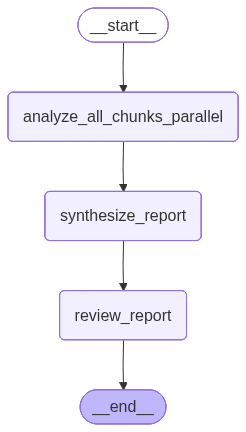

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# 동적 청크 사이즈 결정 함수
def calculate_optimal_chunk_size(total_artifacts: int, target_chunks: int = 100) -> int:
    """
    아티팩트 총 개수에 따라 최적의 청크 사이즈 계산
    
    Args:
        total_artifacts: 전체 아티팩트 개수
        target_chunks: 목표 청크 개수 (기본 100개)
        
    Returns:
        최적화된 청크 사이즈
    """
    # 목표 청크 개수로 나눈 값
    calculated_size = total_artifacts // target_chunks
    
    # 최소/최대 제한 설정
    min_chunk_size = 500   # 너무 작으면 비효율
    max_chunk_size = 2000  # 너무 크면 토큰 초과 위험
    
    # 범위 내로 조정
    optimal_size = max(min_chunk_size, min(calculated_size, max_chunk_size))
    
    # 실제 청크 개수 계산
    actual_chunks = (total_artifacts + optimal_size - 1) // optimal_size
    
    print(f"📊 청크 사이즈 최적화 결과:")
    print(f"  - 전체 아티팩트: {total_artifacts:,}개")
    print(f"  - 청크 사이즈: {optimal_size}개")
    print(f"  - 예상 청크 개수: {actual_chunks}개")
    print(f"  - Map 단계 LLM 호출: {actual_chunks}번")
    print(f"  - 예상 처리 시간: ~{actual_chunks * 2.5:.0f}초 (약 {actual_chunks * 2.5 / 60:.1f}분)")
    
    return optimal_size


# 사용 예시
total = len(artifacts) if 'artifacts' in locals() else 100000
optimal_chunk_size = calculate_optimal_chunk_size(total)

📊 청크 사이즈 최적화 결과:
  - 전체 아티팩트: 100,000개
  - 청크 사이즈: 1000개
  - 예상 청크 개수: 100개
  - Map 단계 LLM 호출: 100번
  - 예상 처리 시간: ~250초 (약 4.2분)


In [ ]:
# 최적화된 실행 버전
from test_artifact_maker import make_test_artifacts

# task_id = "session-20251002-052932-151e52e9"
task_id = "session-20251002-040520-28a9dc6c"
job_id = "test+job_id"

print("🔄 아티팩트 생성 중...")
# artifacts = make_test_artifacts(task_id, limit=10000)
artifacts = make_test_artifacts(task_id)

print(f"\n✅ 총 {len(artifacts):,}개 아티팩트 로드 완료")

# 동적으로 최적 청크 사이즈 계산
optimal_chunk_size = calculate_optimal_chunk_size(len(artifacts), target_chunks=100)

# 청크 분할
artifact_chunks = chunk_artifacts(artifacts, chunk_size=optimal_chunk_size)

print(f"\n🚀 분석 시작...")
initial_state = {
    "artifact_chunks": artifact_chunks,
    "current_chunk_index": 0,
    "intermediate_results": [],
    "final_report": None,
    "job_id": job_id,
    "task_id": task_id
}

import time
start_time = time.time()

recursion_limit = len(artifact_chunks) + 10
final_state = app.invoke(initial_state, config={"recursion_limit": recursion_limit})
elapsed_time = time.time() - start_time

print(f"\n⏱️  총 처리 시간: {elapsed_time:.1f}초 ({elapsed_time/60:.1f}분)")
print(f"📊 처리된 청크: {len(artifact_chunks)}개")
print(f"🔍 필터링된 중요 아티팩트: {sum(len(r.important_artifacts) for r in final_state['intermediate_results'])}개")

print("\n" + "="*80)
print("--- 📋 최종 분석 결과 ---")
print("="*80)
pretty_print_scenario(final_state["final_report"])

🔄 아티팩트 생성 중...
[2025-10-11 23:55:17] DataEncoder - Cookies failed

총 3986개의 artifact 생성됨

✅ 총 3,986개 아티팩트 로드 완료
📊 청크 사이즈 최적화 결과:
  - 전체 아티팩트: 3,986개
  - 청크 사이즈: 500개
  - 예상 청크 개수: 8개
  - Map 단계 LLM 호출: 8번
  - 예상 처리 시간: ~20초 (약 0.3분)

🚀 분석 시작...

🚀 병렬 처리 시작: 8개 청크
✅ 청크 1: 10개 중요 아티팩트 발견
✅ 청크 1: 77개 중요 아티팩트 발견
✅ 청크 1: 2개 중요 아티팩트 발견
✅ 청크 1: 26개 중요 아티팩트 발견
✅ 청크 1: 156개 중요 아티팩트 발견
  진행: 5/8 (62%)
✅ 청크 1: 3개 중요 아티팩트 발견
✅ 청크 1: 342개 중요 아티팩트 발견
✅ 청크 1: 500개 중요 아티팩트 발견
  진행: 8/8 (100%)
✅ 병렬 처리 완료

📊 총 1116개의 중요 아티팩트 발견

🔍 보고서 검토 시작...
  - 원본 Step 개수: 7
  - 원본 아티팩트 참조: 911개
  - 참조 가능한 아티팩트: 1116개

✅ 검토 완료:
  - 원본 Step: 7개 → 개선 Step: 5개
  - 원본 아티팩트: 911개 → 개선 아티팩트: 9개
  - 수정 내역: 증거가 부족하고 추측에 기반한 단계(구직 사이트 검색, 불명확한 파일 다운로드)를 제거했습니다. 아티팩트 데이터가 설명을 뒷받침하지 못하는 단계(디스코드/카카오톡 파일)를 삭제하고, 핵심적인 유출 준비 행위(자료 다운로드, 파일 열람, 외부 프로그램 사용)를 중심으로 5개의 명확한 단계로 재구성하여 보고서의 정확성을 높였습니다.

⏱️  총 처리 시간: 440.6초 (7.3분)
📊 처리된 청크: 8개
🔍 필터링된 중요 아티팩트: 1116개

--- 📋 최종 분석 결과 ---
📜 시나리오 분석 보고서: 메신저를 이용한 내부 자료 유출

[ 보고서 개요 ]
  - 사용자가 회